In [1]:
"""
Based on StyleGAN
https://github.com/rosinality/style-based-gan-pytorch

Author: Mark Peng
"""

%load_ext autoreload
%autoreload 2

# https://docs.fast.ai/dev/gpu.html#gpu-memory-notes
# !pip3 install nvidia-ml-py3

import os
import random, math
from math import sqrt
import time
import copy
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter
from torch.nn.utils import spectral_norm
from torch.autograd import Function, Variable, grad

from torchvision import datasets, transforms, utils
from torchvision.utils import save_image, make_grid

from scipy.stats import truncnorm

import xml.etree.ElementTree as ET
from tqdm import tqdm
import numpy as np
import shutil

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML

import gc
gc.enable()

torch.__version__

'1.1.0'

In [2]:
# kernel_mode = False
kernel_mode = True

if kernel_mode:
    show_metric = False
    show_animation = False
    save_middle_model = False
    
    if show_metric:
        dataset_folder = "../input/generative-dog-images"
        image_folder = "../input/generative-dog-images/all-dogs/all-dogs"
        annotation_folder = "../input/generative-dog-images/annotation"
    else:
        dataset_folder = "../input"
        image_folder = "../input/all-dogs"
        annotation_folder = "../input/annotation"

else:
    show_metric = True
    # show_metric = False
    show_animation = True
    save_middle_model = False
    dataset_folder = "."
    image_folder = "all-dogs"
    annotation_folder = "."

# os.listdir(dataset_folder)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 32

max_training_time = 32_300  # keep 100 seconds for submission
# max_training_time = 32_100  # keep 5 minutes for submission
# max_training_time = 31_800  # keep 10 minutes for submission, approx. iteration: 103_509 (P100)

if kernel_mode:
    max_iterations = 3_000_000
else:
    max_iterations = 112_000

code_size = 128
n_mlp = 8
n_critic = 1  # accumualte iterations


class Args:
    base_lr = 0.0015
    lr = {8: 0.002, 16: 0.004, 32: 0.006, 64: 0.008} # markpeng - faster learing rate
# lr = {8: 0.0015, 16: 0.003, 32: 0.004, 64: 0.006} # markpeng - faster learing rate
#     lr = {8: 0.0015, 16: 0.002, 32: 0.003, 64: 0.005} # markpeng - faster learing rate
    batch = {8: 128, 16: 64, 32: 32, 64: 32}
    phase = {8: 800_000, 16: 400_000, 32: 400_000, 64: 400_000}
    init_size = 8
    max_size = 64
    mixing = True
    loss = 'r1'  # or 'wgan-gp'


args = Args()

# Beta hyperparam for Adam optimizers
beta1 = 0.0
beta2 = 0.99
# beta1 = 0.5
# beta2 = 0.999

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),  # previous: 0.1
    # transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

if kernel_mode:
    show_animation_iters = 2000
    state_print_iters = 1000
else:
    show_animation_iters = 2000
    state_print_iters = 100

mifid_check_iters = 2000
mifid_check_images = 500
early_stopping_patience = 3

truncnorm_threshold = 1

if show_metric:
    predict_batch_size = 25
else:
    predict_batch_size = 50

In [4]:
start = time.time()

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# Dataset Loader

In [6]:
def load_dataset_images(root, n_samples=25000, image_size=64):
    IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif',
                      '.tiff', '.webp')

    def is_valid_file(x):
        return datasets.folder.has_file_allowed_extension(x, IMG_EXTENSIONS)

    required_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
    ])

    imgs = []
    paths = []
    for root, _, fnames in sorted(os.walk(root)):
        for fname in sorted(fnames)[:min(n_samples, 999999999999999)]:
            path = os.path.join(root, fname)
            paths.append(path)

    for path in paths:
        if is_valid_file(path):
            # Load image
            img = datasets.folder.default_loader(path)

            # Get bounding boxes
            annotation_basename = os.path.splitext(os.path.basename(path))[0]
            annotation_dirname = next(
                dirname
                for dirname in os.listdir(f'{annotation_folder}/Annotation/')
                if dirname.startswith(annotation_basename.split('_')[0]))
            annotation_filename = os.path.join(
                f'{annotation_folder}/Annotation/', annotation_dirname,
                annotation_basename)
            tree = ET.parse(annotation_filename)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                w = np.min((xmax - xmin, ymax - ymin))
                bbox = (xmin, ymin, xmin + w, ymin + w)

                object_img = required_transforms(img.crop(bbox))

                imgs.append(object_img)
                
    print(f"Number of cropped dog images: {len(imgs)}")

    return imgs

# Load all images into memory once for reuse
in_memory_images = load_dataset_images(image_folder)

Number of cropped dog images: 22125


In [7]:
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self,
                 dataset_images=None,
                 transform=None,
                 target_image_size=64):
        self.dataset_images = dataset_images
        self.transform = transform
        self.target_image_size = target_image_size
        self.samples = []

        if self.target_image_size < 64:
            print(f"Resizing images for DataGenerator to {target_image_size}x{target_image_size} ......")
            resize_start_time = time.time()
            required_transforms = transforms.Compose(
                [transforms.Resize(self.target_image_size)])
            for img in dataset_images:
                self.samples.append(required_transforms(img))

            print(f"Time spent on resizing images: " + \
                  f"{(time.time() - resize_start_time):.2f} seconds")
        else:
            self.samples = self.dataset_images

    def __getitem__(self, index):
        sample = self.samples[index]

        if self.transform is not None:
            sample = self.transform(sample)

        return np.asarray(sample)

    def __len__(self):
        return len(self.samples)

In [8]:
def sample_data(batch_size, image_size=8):
    train_data = DataGenerator(
        in_memory_images, transform=transform, target_image_size=image_size)
    train_loader = torch.utils.data.DataLoader(
        train_data, shuffle=True, batch_size=batch_size, num_workers=4)

    return train_loader

In [9]:
# train_loader = sample_data(batch_size, image_size=8)
# train_loader = sample_data(batch_size, image_size=16)
# train_loader = sample_data(batch_size, image_size=32)
# train_loader = sample_data(batch_size, image_size=64)
# next(iter(train_loader)).shape

In [10]:
# Resizing images for DataGenerator to 8x8 ......
# Time spent on resizing images: 0.45 seconds
# Resizing images for DataGenerator to 16x16 ......
# Time spent on resizing images: 0.50 seconds
# Resizing images for DataGenerator to 32x32 ......
# Time spent on resizing images: 0.63 seconds

# torch.Size([32, 3, 64, 64])

# GAN Model Definition

In [11]:
def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(1 - decay, par2[k].data)


def adjust_lr(optimizer, lr):
    for group in optimizer.param_groups:
        mult = group.get('mult', 1)
        group['lr'] = lr * mult


def init_linear(linear):
    init.xavier_normal(linear.weight)
    linear.bias.data.zero_()


def init_conv(conv, glu=True):
    init.kaiming_normal(conv.weight)
    if conv.bias is not None:
        conv.bias.data.zero_()

In [12]:
class EqualLR:
    def __init__(self, name):
        self.name = name

    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()

        return weight * sqrt(2 / fan_in)

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)

        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)


def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)

    return module


class FusedUpsample(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, padding=0):
        super().__init__()

        weight = torch.randn(in_channel, out_channel, kernel_size, kernel_size)
        bias = torch.zeros(out_channel)

        fan_in = in_channel * kernel_size * kernel_size
        self.multiplier = sqrt(2 / fan_in)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias)

        self.pad = padding

    def forward(self, input):
        weight = F.pad(self.weight * self.multiplier, [1, 1, 1, 1])
        weight = (weight[:, :, 1:, 1:] + weight[:, :, :-1, 1:] +
                  weight[:, :, 1:, :-1] + weight[:, :, :-1, :-1]) / 4

        out = F.conv_transpose2d(input,
                               weight,
                               self.bias,
                               stride=2,
                               padding=self.pad)

        return out


class FusedDownsample(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, padding=0):
        super().__init__()

        weight = torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        bias = torch.zeros(out_channel)

        fan_in = in_channel * kernel_size * kernel_size
        self.multiplier = sqrt(2 / fan_in)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias)

        self.pad = padding

    def forward(self, input):
        weight = F.pad(self.weight * self.multiplier, [1, 1, 1, 1])
        weight = (weight[:, :, 1:, 1:] + weight[:, :, :-1, 1:] +
                  weight[:, :, 1:, :-1] + weight[:, :, :-1, :-1]) / 4

        out = F.conv2d(input, weight, self.bias, stride=2, padding=self.pad)

        return out


class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input / torch.sqrt(
            torch.mean(input**2, dim=1, keepdim=True) + 1e-8)


class BlurFunctionBackward(Function):
    @staticmethod
    def forward(ctx, grad_output, kernel, kernel_flip):
        ctx.save_for_backward(kernel, kernel_flip)

        grad_input = F.conv2d(grad_output,
                              kernel_flip,
                              padding=1,
                              groups=grad_output.shape[1])

        return grad_input

    @staticmethod
    def backward(ctx, gradgrad_output):
        kernel, kernel_flip = ctx.saved_tensors

        grad_input = F.conv2d(gradgrad_output,
                              kernel,
                              padding=1,
                              groups=gradgrad_output.shape[1])

        return grad_input, None, None


class BlurFunction(Function):
    @staticmethod
    def forward(ctx, input, kernel, kernel_flip):
        ctx.save_for_backward(kernel, kernel_flip)

        output = F.conv2d(input, kernel, padding=1, groups=input.shape[1])

        return output

    @staticmethod
    def backward(ctx, grad_output):
        kernel, kernel_flip = ctx.saved_tensors

        grad_input = BlurFunctionBackward.apply(grad_output, kernel,
                                                kernel_flip)

        return grad_input, None, None


blur = BlurFunction.apply


class Blur(nn.Module):
    def __init__(self, channel):
        super().__init__()

        weight = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]],
                              dtype=torch.float32)
        weight = weight.view(1, 1, 3, 3)
        weight = weight / weight.sum()
        weight_flip = torch.flip(weight, [2, 3])

        self.register_buffer('weight', weight.repeat(channel, 1, 1, 1))
        self.register_buffer('weight_flip',
                             weight_flip.repeat(channel, 1, 1, 1))

    def forward(self, input):
        return blur(input, self.weight, self.weight_flip)
        # return F.conv2d(input, self.weight, padding=1, groups=input.shape[1])


class EqualConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        conv = conv
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)


class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = equal_lr(linear)

    def forward(self, input):
        return self.linear(input)


class ConvBlock(nn.Module):
    def __init__(
            self,
            in_channel,
            out_channel,
            kernel_size,
            padding,
            kernel_size2=None,
            padding2=None,
            downsample=False,
            fused=False,
    ):
        super().__init__()

        pad1 = padding
        pad2 = padding
        if padding2 is not None:
            pad2 = padding2

        kernel1 = kernel_size
        kernel2 = kernel_size
        if kernel_size2 is not None:
            kernel2 = kernel_size2

        self.conv1 = nn.Sequential(
            EqualConv2d(in_channel, out_channel, kernel1, padding=pad1),
            nn.LeakyReLU(0.2),
        )

        if downsample:
            if fused:
                self.conv2 = nn.Sequential(
                    Blur(out_channel),
                    FusedDownsample(out_channel,
                                    out_channel,
                                    kernel2,
                                    padding=pad2),
                    nn.LeakyReLU(0.2),
                )

            else:
                self.conv2 = nn.Sequential(
                    Blur(out_channel),
                    EqualConv2d(out_channel,
                                out_channel,
                                kernel2,
                                padding=pad2),
                    nn.AvgPool2d(2),
                    nn.LeakyReLU(0.2),
                )

        else:
            self.conv2 = nn.Sequential(
                EqualConv2d(out_channel, out_channel, kernel2, padding=pad2),
                nn.LeakyReLU(0.2),
            )

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)

        return out


class AdaptiveInstanceNorm(nn.Module):
    def __init__(self, in_channel, style_dim):
        super().__init__()

        self.norm = nn.InstanceNorm2d(in_channel)
        self.style = EqualLinear(style_dim, in_channel * 2)

        self.style.linear.bias.data[:
                                    in_channel] = 1  # set bias to 1 for style associated
        self.style.linear.bias.data[in_channel:] = 0

    def forward(self, input, style):
        style = self.style(style).unsqueeze(2).unsqueeze(3)
        gamma, beta = style.chunk(2, 1)

        out = self.norm(input)
        out = gamma * out + beta

        return out


class NoiseInjection(nn.Module):
    def __init__(self, channel):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1, channel, 1, 1))

    def forward(self, image, noise):
        return image + self.weight * noise


class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out


class StyledConvBlock(nn.Module):
    def __init__(
            self,
            in_channel,
            out_channel,
            kernel_size=3,
            padding=1,
            style_dim=code_size,
            initial=False,
            upsample=False,
            fused=False,
    ):
        super().__init__()

        if initial:
            self.conv1 = ConstantInput(in_channel)

        else:
            if upsample:
                if fused:
                    self.conv1 = nn.Sequential(
                        FusedUpsample(in_channel,
                                      out_channel,
                                      kernel_size,
                                      padding=padding),
                        Blur(out_channel),
                    )

                else:
                    self.conv1 = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='nearest'),
                        EqualConv2d(in_channel,
                                    out_channel,
                                    kernel_size,
                                    padding=padding),
                        Blur(out_channel),
                    )

            else:
                self.conv1 = EqualConv2d(in_channel,
                                         out_channel,
                                         kernel_size,
                                         padding=padding)

        self.noise1 = equal_lr(NoiseInjection(out_channel))
        self.adain1 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu1 = nn.LeakyReLU(0.2)

        self.conv2 = EqualConv2d(out_channel,
                                 out_channel,
                                 kernel_size,
                                 padding=padding)
        self.noise2 = equal_lr(NoiseInjection(out_channel))
        self.adain2 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu2 = nn.LeakyReLU(0.2)

    def forward(self, input, style, noise):
        out = self.conv1(input)
        out = self.noise1(out, noise)
        out = self.lrelu1(out)
        out = self.adain1(out, style)

        out = self.conv2(out)
        out = self.noise2(out, noise)
        out = self.lrelu2(out)
        out = self.adain2(out, style)

        return out

In [13]:
class Generator(nn.Module):
    def __init__(self, code_dim, fused=True):
        super().__init__()

        self.progression = nn.ModuleList([
            StyledConvBlock(128, 128, 3, 1, initial=True),  # 4
            StyledConvBlock(128, 128, 3, 1, upsample=True),  # 8
            StyledConvBlock(128, 64, 3, 1, upsample=True),  # 16
            StyledConvBlock(64, 32, 3, 1, upsample=True, fused=fused),  # 32
            StyledConvBlock(32, 16, 3, 1, upsample=True, fused=fused),  # 64

            #             StyledConvBlock(512, 512, 3, 1, initial=True),  # 4
            #             StyledConvBlock(512, 512, 3, 1, upsample=True),  # 8
            #             StyledConvBlock(512, 512, 3, 1, upsample=True),  # 16
            #             StyledConvBlock(512, 512, 3, 1, upsample=True),  # 32
            #             StyledConvBlock(512, 256, 3, 1, upsample=True),  # 64
            #             StyledConvBlock(256, 128, 3, 1, upsample=True, fused=fused),  # 128
            #             StyledConvBlock(128, 64, 3, 1, upsample=True, fused=fused),  # 256
            #             StyledConvBlock(64, 32, 3, 1, upsample=True, fused=fused),  # 512
            #             StyledConvBlock(32, 16, 3, 1, upsample=True, fused=fused),  # 1024
        ])

        self.to_rgb = nn.ModuleList([
            EqualConv2d(128, 3, 1),
            EqualConv2d(128, 3, 1),
            EqualConv2d(64, 3, 1),
            EqualConv2d(32, 3, 1),
            EqualConv2d(16, 3, 1),

            #             EqualConv2d(512, 3, 1),
            #             EqualConv2d(512, 3, 1),
            #             EqualConv2d(512, 3, 1),
            #             EqualConv2d(512, 3, 1),
            #             EqualConv2d(256, 3, 1),
            #             EqualConv2d(128, 3, 1),
            #             EqualConv2d(64, 3, 1),
            #             EqualConv2d(32, 3, 1),
            #             EqualConv2d(16, 3, 1),
        ])

        # self.blur = Blur()

    def forward(self, style, noise, step=0, alpha=-1, mixing_range=(-1, -1)):
        out = noise[0]

        if len(style) < 2:
            inject_index = [len(self.progression) + 1]

        else:
            inject_index = random.sample(list(range(step)), len(style) - 1)

        crossover = 0

        for i, (conv, to_rgb) in enumerate(zip(self.progression, self.to_rgb)):
            if mixing_range == (-1, -1):
                if crossover < len(
                        inject_index) and i > inject_index[crossover]:
                    crossover = min(crossover + 1, len(style))

                style_step = style[crossover]

            else:
                if mixing_range[0] <= i <= mixing_range[1]:
                    style_step = style[1]

                else:
                    style_step = style[0]

            if i > 0 and step > 0:
                out_prev = out

                out = conv(out, style_step, noise[i])

            else:
                out = conv(out, style_step, noise[i])

            if i == step:
                out = to_rgb(out)

                if i > 0 and 0 <= alpha < 1:
                    skip_rgb = self.to_rgb[i - 1](out_prev)
                    skip_rgb = F.interpolate(skip_rgb,
                                             scale_factor=2,
                                             mode='nearest')
                    out = (1 - alpha) * skip_rgb + alpha * out

                break

        return out


class StyledGenerator(nn.Module):
    def __init__(self, code_dim=128, n_mlp=8):
        super().__init__()

        self.generator = Generator(code_dim)

        layers = [PixelNorm()]
        for i in range(n_mlp):
            layers.append(EqualLinear(code_dim, code_dim))
            layers.append(nn.LeakyReLU(0.2))

        self.style = nn.Sequential(*layers)

    def forward(
            self,
            input,
            noise=None,
            step=0,
            alpha=-1,
            mean_style=None,
            style_weight=0,
            mixing_range=(-1, -1),
    ):
        styles = []
        if type(input) not in (list, tuple):
            input = [input]

        for i in input:
            styles.append(self.style(i))

        batch = input[0].shape[0]

        if noise is None:
            noise = []

            for i in range(step + 1):
                size = 4 * 2**i
                noise.append(
                    torch.randn(batch, 1, size, size, device=input[0].device))

        if mean_style is not None:
            styles_norm = []

            for style in styles:
                styles_norm.append(mean_style + style_weight *
                                   (style - mean_style))

            styles = styles_norm

        return self.generator(styles,
                              noise,
                              step,
                              alpha,
                              mixing_range=mixing_range)

    def mean_style(self, input):
        style = self.style(input).mean(0, keepdim=True)

        return style

In [14]:
class Discriminator(nn.Module):
    def __init__(self, fused=True):
        super().__init__()

        self.progression = nn.ModuleList([
            ConvBlock(16, 32, 3, 1, downsample=True, fused=fused),  # 64
            ConvBlock(32, 64, 3, 1, downsample=True, fused=fused),  # 32
            ConvBlock(64, 128, 3, 1, downsample=True),  # 14
            ConvBlock(128, 128, 3, 1, downsample=True),  # 8
            ConvBlock(129, 128, 3, 1, 4, 0),  # 4

            #             ConvBlock(16, 32, 3, 1, downsample=True, fused=fused),  # 512
            #             ConvBlock(32, 64, 3, 1, downsample=True, fused=fused),  # 256
            #             ConvBlock(64, 128, 3, 1, downsample=True, fused=fused),  # 128
            #             ConvBlock(128, 256, 3, 1, downsample=True, fused=fused),  # 64
            #             ConvBlock(256, 512, 3, 1, downsample=True),  # 32
            #             ConvBlock(512, 512, 3, 1, downsample=True),  # 16
            #             ConvBlock(512, 512, 3, 1, downsample=True),  # 8
            #             ConvBlock(512, 512, 3, 1, downsample=True),  # 4
            #             ConvBlock(513, 512, 3, 1, 4, 0),
        ])

        self.from_rgb = nn.ModuleList([
            EqualConv2d(3, 16, 1),
            EqualConv2d(3, 32, 1),
            EqualConv2d(3, 64, 1),
            EqualConv2d(3, 128, 1),
            EqualConv2d(3, 128, 1),

            #             EqualConv2d(3, 16, 1),
            #             EqualConv2d(3, 32, 1),
            #             EqualConv2d(3, 64, 1),
            #             EqualConv2d(3, 128, 1),
            #             EqualConv2d(3, 256, 1),
            #             EqualConv2d(3, 512, 1),
            #             EqualConv2d(3, 512, 1),
            #             EqualConv2d(3, 512, 1),
            #             EqualConv2d(3, 512, 1),
        ])

        # self.blur = Blur()

        self.n_layer = len(self.progression)

        self.linear = EqualLinear(code_size, 1)


#         self.linear = EqualLinear(512, 1)

    def forward(self, input, step=0, alpha=-1):
        for i in range(step, -1, -1):
            index = self.n_layer - i - 1

            if i == step:
                out = self.from_rgb[index](input)

            if i == 0:
                # Minibatch stddev
                out_std = torch.sqrt(out.var(0, unbiased=False) + 1e-8)
                mean_std = out_std.mean()
                mean_std = mean_std.expand(out.size(0), 1, 4, 4)
                out = torch.cat([out, mean_std], 1)

            out = self.progression[index](out)

            if i > 0:
                if i == step and 0 <= alpha < 1:
                    skip_rgb = F.avg_pool2d(input, 2)
                    skip_rgb = self.from_rgb[index + 1](skip_rgb)

                    out = (1 - alpha) * skip_rgb + alpha * out

        out = out.squeeze(2).squeeze(2)
        # print(input.size(), out.size(), step)
        out = self.linear(out)

        return out

# MiFID Inference Model

In [15]:
import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

In [16]:
class KernelEvalException(Exception):
    pass

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.GFile(pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='Pretrained_Net')


def _get_model_layer(sess, model_name):
    # layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
                shape = [s.value for s in shape]
                new_shape = []
                for j, s in enumerate(shape):
                    if s == 1 and j == 0:
                        new_shape.append(None)
                    else:
                        new_shape.append(s)
                o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer


def get_activations(images, sess, model_name, batch_size=32, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print(
            "warning: batch size is bigger than the data size. setting batch size to data size"
        )
        batch_size = n_images
    n_batches = n_images // batch_size + 1
    pred_arr = np.empty((n_images, model_params[model_name]['output_shape']))
    for i in range(n_batches):
    # for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i + 1, n_batches),
                  end="",
                  flush=True)
        start = i * batch_size
        if start + batch_size < n_images:
            end = start + batch_size
        else:
            end = n_images

        batch = images[start:end]
        pred = sess.run(inception_layer,
                        {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(
            -1, model_params[model_name]['output_shape'])
    return pred_arr


def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x / np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0 - np.abs(np.matmul(norm_f1, norm_f2.T))
    mean_min_d = np.mean(np.min(d, axis=1))
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(
        sigma2) - 2 * tr_covmean


#-------------------------------------------------------------------------------


def calculate_activation_statistics(images,
                                    sess,
                                    model_name,
                                    batch_size=32,
                                    verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act


def _handle_path_memorization(path, sess, model_name, n_images,
                              is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))

    seed_everything()
    np.random.shuffle(files)
    files = files[:n_images]
    
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose.
    x = np.array([
        np.array(
            img_read_checks(fn, imsize, is_checksize, imsize, is_check_png))
        for fn in files
    ])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x  #clean up memory
    gc.collect()
    return m, s, features


# check for image size
def img_read_checks(filename,
                    resize_to,
                    is_checksize=False,
                    check_imsize=64,
                    is_check_png=False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize, check_imsize):
        raise KernelEvalException('The images are not of size ' +
                                  str(check_imsize))

    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to, resize_to), Image.ANTIALIAS)


def calculate_kid_given_paths(paths, model_name, model_path,
                              n_images=1000,
                              feature_path=None):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0],
                                                      sess,
                                                      model_name,
                                                      n_images=n_images,
                                                      is_checksize=True,
                                                      is_check_png=True)
        if feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1],
                                                          sess,
                                                          model_name,
                                                          n_images=n_images,
                                                          is_checksize=False,
                                                          is_check_png=False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        distance = cosine_distance(features1, features2)
        return fid_value, distance

In [17]:
model_params = {
    'Inception': {
        'name': 'Inception',
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0',
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
    }
}

user_images_unzipped_path = '../output_images'
images_path = [user_images_unzipped_path, image_folder]
if kernel_mode:
    public_path = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'
else:
    public_path = 'classify_image_graph_def.pb'
fid_epsilon = 10e-15

In [18]:
def compute_MiFID(n_images=1000):
    seed_everything()
    tf.set_random_seed(42)
    fid_value_public, distance_public = calculate_kid_given_paths(
        images_path, 'Inception', public_path, n_images)
    distance_public = distance_thresholding(
        distance_public, model_params['Inception']['cosine_distance_eps'])
    miFID = fid_value_public / (distance_public + fid_epsilon)
    print(
        f"FID_public: {fid_value_public}, distance_public: {distance_public} "
        + f"multiplied_public: {miFID}")
    return miFID

# Style-GAN

In [19]:
# From https://www.kaggle.com/sakami/ralsgan-dogs-cropping-random?scriptVersionId=17526139
# Large Scale GAN Training for High Fidelity Natural Image Synthesis
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values


def show_generated_img_all(num_samples=64, figsize=(20, 20)):
    with torch.no_grad():
        gen_images = g_running(torch.randn(num_samples, code_size).cuda(),
                               step=step,
                               alpha=alpha).data.cpu()
        # gen_images = ((gen_images + 1.0) / 2.0)

    # Plot the real images
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(
        np.transpose(
            make_grid(gen_images, padding=2, normalize=True,
                      range=(-1, 1)).cpu(), (1, 2, 0)))

    # plt.savefig(filename)


### This is to show one sample image for iteration of chosing
def show_generated_img(iteration):
    with torch.no_grad():
        gen_images = g_running(torch.randn(4, code_size).cuda(),
                               step=step,
                               alpha=alpha).data.cpu()
        # gen_images = ((gen_images + 1.0) / 2.0)

    # Plot the real images
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 4, 1)
    plt.title(f"Iteration {iteration+1}")
    plt.axis("off")
    plt.imshow(
        np.transpose(
            make_grid(gen_images, padding=2, normalize=True,
                      range=(-1, 1)).cpu(), (1, 2, 0)))

    plt.show()


def generate_validation_images(threshold=1, n_images=1000):
    if not os.path.exists('../output_images'):
        os.mkdir('../output_images')
    else:
        shutil.rmtree('../output_images', ignore_errors=True)
        os.mkdir('../output_images')

    im_batch_size = predict_batch_size
    for i_batch in range(0, n_images, im_batch_size):
        z = truncated_normal((im_batch_size, code_size), threshold=threshold)
        gen_z = torch.from_numpy(z).float().to(device)

        with torch.no_grad():
            gen_images = g_running(gen_z, step=step, alpha=alpha).data.cpu()

        images = gen_images.to("cpu").clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)

        for i_image in range(gen_images.size(0)):
            # Suggestion by Chris
            # https://www.kaggle.com/wendykan/gan-dogs-starter/notebook#573699
            # new_image = (gen_images[i_image, :, :, :] + 1.0) / 2.0

            new_image = gen_images[i_image, :, :, :]
            save_image(new_image,
                       os.path.join('../output_images',
                                    f'image_{i_batch+i_image:05d}.png'),
                       normalize=True,
                       range=(-1, 1))

    generated_image_count = len(
        [name for name in os.listdir('../output_images')])
    print(f"Number of generated images: {generated_image_count}")


class EarlyStoppingCriterion(object):
    def __init__(self, patience, mode, min_delta=0.0):
        assert patience >= 0 and mode in {'min', 'max'} and min_delta >= 0.0
        self.patience, self.mode, self.min_delta = patience, mode, min_delta
        self._count, self._best_score, self.is_improved = 0, None, None

    def step(self, cur_score):
        if self._best_score is None:
            self._best_score = cur_score
            return True
        else:
            if self.mode == 'max':
                self.is_improved = (cur_score >=
                                    self._best_score + self.min_delta)
            else:
                self.is_improved = (cur_score <=
                                    self._best_score - self.min_delta)

            if self.is_improved:
                self._count = 0
                self._best_score = cur_score
            else:
                self._count += 1
            return self._count <= self.patience

    def state_dict(self):
        return self.__dict__

    def load_state_dict(self, state_dict):
        self.__dict__.update(state_dict)

In [20]:
generator = StyledGenerator(code_size, n_mlp).cuda()
discriminator = Discriminator().cuda()
g_running = StyledGenerator(code_size, n_mlp).cuda()
g_running.train(False)

StyledGenerator(
  (generator): Generator(
    (progression): ModuleList(
      (0): StyledConvBlock(
        (conv1): ConstantInput()
        (noise1): NoiseInjection()
        (adain1): AdaptiveInstanceNorm(
          (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (style): EqualLinear(
            (linear): Linear(in_features=128, out_features=256, bias=True)
          )
        )
        (lrelu1): LeakyReLU(negative_slope=0.2)
        (conv2): EqualConv2d(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (noise2): NoiseInjection()
        (adain2): AdaptiveInstanceNorm(
          (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (style): EqualLinear(
            (linear): Linear(in_features=128, out_features=256, bias=True)
          )
        )
        (lrelu2): LeakyReLU(negative_slope=0.2)
      )
      (1): StyledCo

In [21]:
print(discriminator)

Discriminator(
  (progression): ModuleList(
    (0): ConvBlock(
      (conv1): Sequential(
        (0): EqualConv2d(
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): LeakyReLU(negative_slope=0.2)
      )
      (conv2): Sequential(
        (0): Blur()
        (1): FusedDownsample()
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): ConvBlock(
      (conv1): Sequential(
        (0): EqualConv2d(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): LeakyReLU(negative_slope=0.2)
      )
      (conv2): Sequential(
        (0): Blur()
        (1): FusedDownsample()
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): ConvBlock(
      (conv1): Sequential(
        (0): EqualConv2d(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): LeakyReLU(negative_slope=0.2)
      )
      (conv2): Sequential(
    

In [22]:
g_optimizer = optim.Adam(generator.generator.parameters(),
                         lr=args.base_lr,
                         betas=(beta1, beta2))
g_optimizer.add_param_group({
    'params': generator.style.parameters(),
    'lr': args.base_lr * 0.01,
    'mult': 0.01,
})
d_optimizer = optim.Adam(discriminator.parameters(),
                         lr=args.base_lr,
                         betas=(beta1, beta2))

accumulate(g_running, generator, 0)

In [23]:
# https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/13
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def save_models(model_name):
    torch.save(
        {
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'g_optimizer': g_optimizer.state_dict(),
            'd_optimizer': d_optimizer.state_dict(),
            'g_running': g_running.state_dict()
        },
        f'{model_name}.model',
    )


print(
    f"Generator Model Size: {count_parameters(generator):,} trainable parameters"
)
print(
    f"Discriminator Model Size: {count_parameters(discriminator):,} trainable parameters"
)

Generator Model Size: 914,015 trainable parameters
Discriminator Model Size: 998,529 trainable parameters


# Training

In [24]:
# Redirect outputs to console
import sys
if not kernel_mode:
    jupyter_console = sys.stdout
    sys.stdout = open('/dev/stdout', 'w')
    # Append to log file
    # sys.stdout = open(f"stdout.log", 'a')
    # sys.stdout = jupyter_console

In [25]:
torch.cuda.empty_cache()

In [26]:
early_stopper = EarlyStoppingCriterion(patience=early_stopping_patience,
                                       mode='min',
                                       min_delta=1e-4)

G_losses = []
D_losses = []
disc_loss_val = 0
gen_loss_val = 0
grad_loss_val = 0

gc.collect()

print("Starting Training Loop...")

train_start_time = time.time()

alpha = 0
used_sample = 0

step = int(math.log2(args.init_size)) - 2
resolution = 4 * 2**step
phase = args.phase.get(resolution, 400_000)

loader = sample_data(args.batch.get(resolution, batch_size),
                     image_size=resolution)
data_loader = iter(loader)

max_step = int(math.log2(args.max_size)) - 2  # 4
final_progress = False

adjust_lr(g_optimizer, args.lr.get(resolution, args.base_lr))
adjust_lr(d_optimizer, args.lr.get(resolution, args.base_lr))
requires_grad(generator, False)
requires_grad(discriminator, True)

print(f"Training with resolution {resolution}x{resolution} (" + \
      f"step: {step}, batch_size: {args.batch.get(resolution, batch_size)}, " + \
      f"Generator LR: {g_optimizer.state_dict()['param_groups'][0]['lr']}, " + \
      f"Style LR: {g_optimizer.state_dict()['param_groups'][1]['lr']}, " + \
      f"Discriminator LR: {d_optimizer.state_dict()['param_groups'][0]['lr']})")

go_ahead = True
for iters in range(max_iterations):
    if not go_ahead:
        break

    gc.collect()

    iter_start_time = time.time()

    end = time.time()
    if (end - start) > max_training_time:
        print(
            f"Trained over {max_training_time:,} seconds, stopped at iteration {iters+1}"
        )
        go_ahead = False
        break

    discriminator.zero_grad()

    alpha = min(1, 1 / phase * (used_sample + 1))

    if resolution == args.init_size or final_progress:
        alpha = 1

    if used_sample > phase * 2:
        used_sample = 0
        step += 1

        if step > max_step:
            step = max_step
            final_progress = True
        else:
            alpha = 0

        resolution = 4 * 2**step
        phase = args.phase.get(resolution, 400_000)

        del loader
        gc.collect()
        loader = sample_data(args.batch.get(resolution, batch_size),
                             image_size=resolution)
        data_loader = iter(loader)

        # if save_middle_model:
        #     save_models(f'stylegan_step-{step}')

        adjust_lr(g_optimizer, args.lr.get(resolution, args.base_lr))
        adjust_lr(d_optimizer, args.lr.get(resolution, args.base_lr))

        print(f"Training with resolution {resolution}x{resolution} (" + \
              f"step: {step}, batch_size: {args.batch.get(resolution, batch_size)}, " + \
              f"Generator LR: {g_optimizer.state_dict()['param_groups'][0]['lr']}, " + \
              f"Style LR: {g_optimizer.state_dict()['param_groups'][1]['lr']}, " + \
              f"Discriminator LR: {d_optimizer.state_dict()['param_groups'][0]['lr']})")

    try:
        real_image = next(data_loader)

    except (OSError, StopIteration):
        data_loader = iter(loader)
        real_image = next(data_loader)

    used_sample += real_image.shape[0]

    b_size = real_image.size(0)
    real_image = real_image.cuda()

    if args.loss == 'wgan-gp':
        real_predict = discriminator(real_image, step=step, alpha=alpha)
        real_predict = real_predict.mean() - 0.001 * (real_predict**2).mean()
        (-real_predict).backward()

    elif args.loss == 'r1':
        real_image.requires_grad = True
        real_predict = discriminator(real_image, step=step, alpha=alpha)
        real_predict = F.softplus(-real_predict).mean()
        real_predict.backward(retain_graph=True)

        grad_real = grad(outputs=real_predict.sum(),
                         inputs=real_image,
                         create_graph=True)[0]
        grad_penalty = (grad_real.view(grad_real.size(0),
                                       -1).norm(2, dim=1)**2).mean()
        grad_penalty = 10 / 2 * grad_penalty
        grad_penalty.backward()
        grad_loss_val = grad_penalty.item()

    if args.mixing and random.random() < 0.9:
        gen_in11, gen_in12, gen_in21, gen_in22 = torch.randn(
            4, b_size, code_size, device='cuda').chunk(4, 0)
        gen_in1 = [gen_in11.squeeze(0), gen_in12.squeeze(0)]
        gen_in2 = [gen_in21.squeeze(0), gen_in22.squeeze(0)]

    else:
        gen_in1, gen_in2 = torch.randn(2, b_size, code_size,
                                       device='cuda').chunk(2, 0)
        gen_in1 = gen_in1.squeeze(0)
        gen_in2 = gen_in2.squeeze(0)

    fake_image = generator(gen_in1, step=step, alpha=alpha)
    fake_predict = discriminator(fake_image, step=step, alpha=alpha)

    if args.loss == 'wgan-gp':
        fake_predict = fake_predict.mean()
        fake_predict.backward()

        eps = torch.rand(b_size, 1, 1, 1).cuda()
        x_hat = eps * real_image.data + (1 - eps) * fake_image.data
        x_hat.requires_grad = True
        hat_predict = discriminator(x_hat, step=step, alpha=alpha)
        grad_x_hat = grad(outputs=hat_predict.sum(),
                          inputs=x_hat,
                          create_graph=True)[0]
        grad_penalty = (
            (grad_x_hat.view(grad_x_hat.size(0), -1).norm(2, dim=1) -
             1)**2).mean()
        grad_penalty = 10 * grad_penalty
        grad_penalty.backward()
        grad_loss_val = grad_penalty.item()
        disc_loss_val = (real_predict - fake_predict).item()

    elif args.loss == 'r1':
        fake_predict = F.softplus(fake_predict).mean()
        fake_predict.backward()
        disc_loss_val = (real_predict + fake_predict).item()

    d_optimizer.step()

    if (iters + 1) % n_critic == 0:
        generator.zero_grad()

        requires_grad(generator, True)
        requires_grad(discriminator, False)

        fake_image = generator(gen_in2, step=step, alpha=alpha)

        predict = discriminator(fake_image, step=step, alpha=alpha)

        if args.loss == 'wgan-gp':
            loss = -predict.mean()

        elif args.loss == 'r1':
            loss = F.softplus(-predict).mean()

        gen_loss_val = loss.item()

        loss.backward()
        g_optimizer.step()
        accumulate(g_running, generator)

        requires_grad(generator, False)
        requires_grad(discriminator, True)

    if show_animation and (iters + 1) % show_animation_iters == 0:
        show_generated_img(iters)

    if (iters + 1) % state_print_iters == 0:
        print(f"[{iters+1}/{max_iterations}] Phase Size:{phase}, " + \
              f"Resolution: {4 * 2 ** step}, " + \
              f"Loss_G: {gen_loss_val:.4f}, " + \
              f"Loss_D: {disc_loss_val:.4f}, " + \
              f"Grad: {grad_loss_val:.4f}, Alpha: {alpha:.5f}, Used Samples: {used_sample:,}")
        print(f"Time spent on iteration {iters+1}: " + \
              f"{(time.time() - iter_start_time):.2f} seconds")

        # Save Losses for plotting later
        G_losses.append(gen_loss_val)
        D_losses.append(disc_loss_val)

        if show_metric and (
            (iters + 1) %
                mifid_check_iters) == 0 and resolution == args.max_size:
            generate_validation_images(threshold=truncnorm_threshold,
                                       n_images=mifid_check_images)
            val_mifid = compute_MiFID(mifid_check_images)

            if early_stopper.step(val_mifid):
                if early_stopper.is_improved:
                    best_score = val_mifid
                    best_iters = iters
                    print(
                        f'MiFID Improved: {val_mifid:.4f}, saving model ......'
                    )

                    # save_models(f'stylegan_{iters+1}iters')
                else:
                    print('No improvements in this iteration')
                    gc.collect()
            else:
                print(
                    f'No more improvement....(Best MiFID: {best_score:.6f}, {best_iters+1} iterations)'
                )
                gc.collect()
                break

if show_metric:
    print(f'Best MiFID: {best_score:.6f}, {best_iters+1} iterations')
else:
    best_iters = iters
print(f"Total time spent on training: " + \
      f"{(time.time() - train_start_time)/60:.2f} minutes " + \
      f"({best_iters + 1} iterations, step: {step}, alpha: {alpha})")

Starting Training Loop...
Resizing images for DataGenerator to 8x8 ......
Time spent on resizing images: 0.61 seconds
Training with resolution 8x8 (step: 1, batch_size: 128, Generator LR: 0.002, Style LR: 2e-05, Discriminator LR: 0.002)
[1000/3000000] Phase Size:800000, Resolution: 8, Loss_G: 4.2297, Loss_D: 0.2151, Grad: 0.0011, Alpha: 1.00000, Used Samples: 127,905
Time spent on iteration 1000: 0.08 seconds
[2000/3000000] Phase Size:800000, Resolution: 8, Loss_G: 2.6656, Loss_D: 0.4126, Grad: 0.0018, Alpha: 1.00000, Used Samples: 255,791
Time spent on iteration 2000: 0.08 seconds
[3000/3000000] Phase Size:800000, Resolution: 8, Loss_G: 2.5631, Loss_D: 0.5717, Grad: 0.0050, Alpha: 1.00000, Used Samples: 383,677
Time spent on iteration 3000: 0.08 seconds
[4000/3000000] Phase Size:800000, Resolution: 8, Loss_G: 2.5206, Loss_D: 0.7825, Grad: 0.0055, Alpha: 1.00000, Used Samples: 511,563
Time spent on iteration 4000: 0.08 seconds
[5000/3000000] Phase Size:800000, Resolution: 8, Loss_G: 1.

In [27]:
# [219300/3000000] Phase:400000, Resolution: 64, Loss_G: 7.3933, Loss_D: 0.0653, Grad: 0.0087, Alpha: 1.00000, Used Samples: 710,848
# Time spent on iteration 219300: 0.10 seconds
# Trained over 30,000 seconds, stopped at iteration 219363
# Total time spent on training: 499.20 minutes (219363 iterations)

In [28]:
if not show_metric:
    final_model = f'stylegan_{best_iters+1}iters'
    save_models(final_model)
    print(f"{final_model}.model saved.")

stylegan_123242iters.model saved.


## Loss versus training iteration

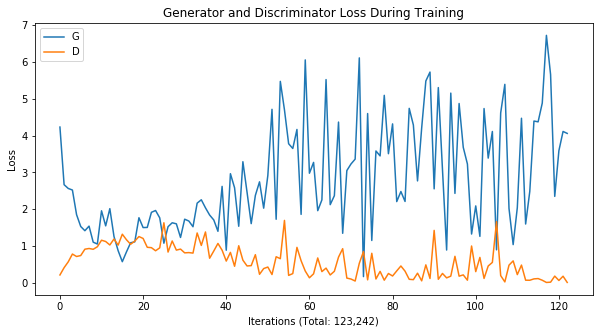

In [29]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel(f"Iterations (Total: {best_iters+1:,})")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generate Submission

In [30]:
# models = torch.load(f"stylegan_{best_iters+1}iters.model")
# generator.load_state_dict(models["generator"])
# discriminator.load_state_dict(models["discriminator"])
# g_running.load_state_dict(models["g_running"])

In [31]:
# From https://www.kaggle.com/sakami/ralsgan-dogs-cropping-random?scriptVersionId=17526139
# Large Scale GAN Training for High Fidelity Natural Image Synthesis
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

In [32]:
%%time

if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
else:
    shutil.rmtree('../output_images', ignore_errors=True)
    os.mkdir('../output_images')

# im_batch_size = 25
im_batch_size = 50
n_images = 10000

first_batch = []
for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, code_size),
                         threshold=truncnorm_threshold)
    gen_z = torch.from_numpy(z).float().to(device)

    with torch.no_grad():
        gen_images = g_running(gen_z, step=step, alpha=alpha).data.cpu()
        # Suggestion by Chris
        # https://www.kaggle.com/wendykan/gan-dogs-starter/notebook#573699
        # gen_images = ((gen_images + 1.0) / 2.0)

    for i_image in range(gen_images.size(0)):
        new_image = gen_images[i_image, :, :, :]

        if i_batch == 0:
            first_batch.append(new_image)

        save_image(new_image,
                   os.path.join('../output_images',
                                f'image_{i_batch+i_image:05d}.png'),
                   normalize=True,
                   range=(-1, 1))

generated_image_count = len([name for name in os.listdir('../output_images')])
print(f"Number of generated images: {generated_image_count}")

shutil.make_archive('images', 'zip', '../output_images')

Number of generated images: 10000
CPU times: user 14.3 s, sys: 2.31 s, total: 16.7 s
Wall time: 16.7 s


'/kaggle/working/images.zip'

In [33]:
# Plot the saved images
# plt.figure(figsize=(20, 20))
# plt.subplot(1, 2, 1)
# plt.axis("off")
# plt.title("Submission Images")
# plt.imshow(
#     np.transpose(
#         make_grid(first_batch, padding=2, normalize=True, range=(-1, 1)).cpu(),
#         (1, 2, 0)))

CPU times: user 32 ms, sys: 8 ms, total: 40 ms
Wall time: 49.2 ms


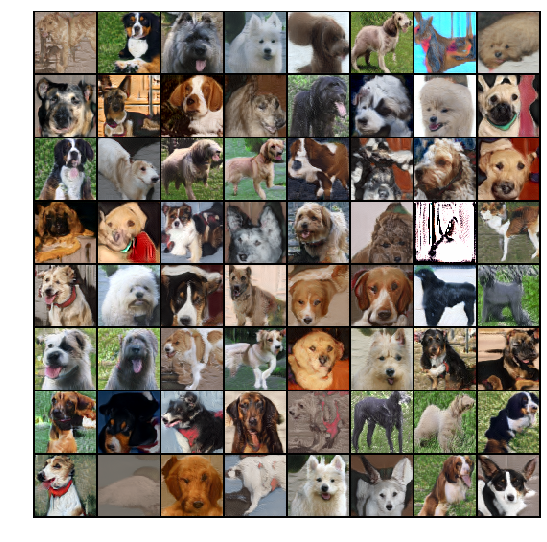

In [34]:
%%time

show_generated_img_all(64)